In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from acv_explainers import ACXplainer
from acv_explainers.utils import *
from sklearn.metrics import roc_auc_score, accuracy_score
import argparse
import numpy as np
# from acv_explainers.utils import generate_dataset
# from experiments.utils import feature_performance_metric, prediction_performance_metric   
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
# from skranger.ensemble.classifier import RangerForestClassifier
from sklearn.ensemble import RandomForestRegressor
from acv_explainers.acv_tree import ACVTreeAgnostic
# Necessary packages
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
import itertools
from collections import defaultdict
from operator import itemgetter
import string
import random
import scipy.stats as stats
from typing import Tuple, List
from sklearn.cluster import AffinityPropagation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn import datasets

# Generate Moon Data

In [2]:
def generate_x(n, dim):
    """Generate the features (x).

  Args:
    - n: the number of samples
    - dim: the number of features (feature dimensions)

  Returns:
    - x: (n x dim) data points sample from N(0, 1)
  """
    x = np.random.randn(n, dim)
    return x


def generate_y(x, data_type, reg=False, coefs=None, logit_values=True):
    """Generate corresponding label (y) given feature (x).

  Args:
    - x: features
    - data_type: synthetic data type (syn1 to syn6)

  Returns:
    - y: corresponding labels
  """
    # number of samples
    n = x.shape[0]
    if reg:
        if data_type == 'syn7':
            logit1 = np.sum(coefs[0:2] * x[:, 0:2], axis=1)
            logit2 = np.sum(coefs[2:4] * x[:, 2:4], axis=1)
            idx1 = (x[:, 4] < 0) * 1
            idx2 = (x[:, 4] >= 0) * 1
            logit = logit1 * idx1 + logit2 * idx2
            return logit
        elif data_type == 'syn8':
            return np.sum(coefs[:3] * x[:, :3], axis=1)
        elif data_type == 'syn9':
            logit1 = np.sum(x[:, 2:6] ** 2, axis=1) - 4.0
            logit2 = -10 * np.sin(0.2 * x[:, 6]) + abs(x[:, 7]) + \
                     x[:, 8] + np.exp(-x[:, 9]) - 2.4

            idx1 = (x[:, 10] < 0) * 1
            idx2 = (x[:, 10] >= 0) * 1
            logit = logit1 * idx1 + logit2 * idx2
            return logit

    # Logit computation
    if data_type == 'syn1':
        logit = np.exp(x[:, 0] * x[:, 1])
    elif data_type == 'syn2':
        logit = np.exp(np.sum(x[:, 2:6] ** 2, axis=1) - 4.0)
    elif data_type == 'syn3':
        logit = np.exp(-10 * np.sin(0.2 * x[:, 6]) + abs(x[:, 7]) + \
                       x[:, 8] + np.exp(-x[:, 9]) - 2.4)
    elif data_type == 'syn4':
        logit1 = np.exp(x[:, 0] * x[:, 1])
        logit2 = np.exp(np.sum(x[:, 2:6] ** 2, axis=1) - 4.0)
    elif data_type == 'syn5':
        logit1 = np.exp(x[:, 0] * x[:, 1])
        logit2 = np.exp(-10 * np.sin(0.2 * x[:, 6]) + abs(x[:, 7]) + \
                        x[:, 8] + np.exp(-x[:, 9]) - 2.4)
    elif data_type == 'syn6':
        logit1 = np.exp(np.sum(x[:, 2:6] ** 2, axis=1) - 4.0)
        logit2 = np.exp(-10 * np.sin(0.2 * x[:, 6]) + abs(x[:, 7]) + \
                        x[:, 8] + np.exp(-x[:, 9]) - 2.4)

        # For syn4, syn5 and syn6 only
    if data_type in ['syn4', 'syn5', 'syn6']:
        # Based on X[:,10], combine two logits
        idx1 = (x[:, 10] < 0) * 1
        idx2 = (x[:, 10] >= 0) * 1
        logit = logit1 * idx1 + logit2 * idx2

    if not logit_values:
        # Compute P(Y=0|X)
        prob_0 = np.reshape((logit / (1 + logit)), [n, 1])

        # # Sampling process
        y = np.zeros([n, 2])
        y[:, 0] = np.reshape(np.random.binomial(1, prob_0), [n, ])
        y[:, 1] = 1 - y[:, 0]
        return y[:, 1]
    return logit / (1 + logit)


def generate_ground_truth(x, data_type):
    """Generate ground truth feature importance corresponding to the data type
     and feature.

  Args:
    - x: features
    - data_type: synthetic data type (syn1 to syn6)

  Returns:
    - ground_truth: corresponding ground truth feature importance
  """

    # Number of samples and features
    n, d = x.shape

    # Output initialization
    ground_truth = np.zeros([n, d])

    # For each data_type
    if data_type == 'syn1':
        ground_truth[:, :2] = 1
    elif data_type == 'syn2':
        ground_truth[:, 2:6] = 1
    elif data_type == 'syn3':
        ground_truth[:, 6:10] = 1

    # Index for syn4, syn5 and syn6
    if data_type in ['syn4', 'syn5', 'syn6', 'syn9']:
        idx1 = np.where(x[:, 10] < 0)[0]
        idx2 = np.where(x[:, 10] >= 0)[0]
        ground_truth[:, 10] = 1

    if data_type == 'syn4':
        ground_truth[idx1, :2] = 1
        ground_truth[idx2, 2:6] = 1
    elif data_type == 'syn5':
        ground_truth[idx1, :2] = 1
        ground_truth[idx2, 6:10] = 1
    elif data_type == 'syn6':
        ground_truth[idx1, 2:6] = 1
        ground_truth[idx2, 6:10] = 1
    elif data_type == 'syn7':
        idx1 = np.where(x[:, 4] < 0)[0]
        idx2 = np.where(x[:, 4] >= 0)[0]
        ground_truth[:, 4] = 1

        ground_truth[idx1, 0:2] = 1
        ground_truth[idx2, 2:4] = 1
    elif data_type == 'syn8':
        ground_truth[:, :3] = 1
        # ground_truth[idx2, 6:10] = 1
    elif data_type == 'syn9':
        ground_truth[idx1, :2] = 1
        ground_truth[idx2, 6:10] = 1

    return ground_truth


def generate_moons(x):
    moon_x, y = datasets.make_moons(n_samples=x.shape[0], noise=4 * 0.01)
    x = np.concatenate([moon_x, x], axis=1)
    for i in range(x.shape[0]):
        if x[i, 2] <= 0:
            if y[i] == 0:
                y[i] = 1
            else:
                y[i] = 0
    ground_truth = np.zeros(shape=x.shape)
    ground_truth[:, :3] = 1
    return x, y, ground_truth


def generate_dataset(mean, cov, n=10000, dim=11, data_type='syn1', seed=0, reg=False, coefs=None, logit_values=True):
    """Generate dataset (x, y, ground_truth).

  Args:
    - n: the number of samples
    - dim: the number of dimensions
    - data_type: synthetic data type (syn1 to syn6)
    - seed: random seed

  Returns:
    - x: features
    - y: labels
    - ground_truth: ground truth feature importance
  """

    # Seed
    np.random.seed(seed)

    # x generation
    data_gen = st.multivariate_normal(mean, cov)
    x = data_gen.rvs(n)
    if data_type == 'syn_moons':
        x, y, ground_truth = generate_moons(x)
        return x, y, ground_truth

    # x = generate_x(n, dim)
    # y generation
    y = generate_y(x, data_type, reg, coefs, logit_values)
    # ground truth generation
    ground_truth = generate_ground_truth(x, data_type)

    return x, y, ground_truth
parser = argparse.ArgumentParser()
parser.add_argument(
  '--data_type',
  choices=['syn1','syn2','syn3','syn4','syn5','syn6', 'syn7', 'syn8', 'syn_moons'],
  default='syn_moons',
  type=str)
parser.add_argument(
  '--train_no',
  help='the number of training data',
  default=10000,
  type=int)
parser.add_argument(
  '--test_no',
  help='the number of testing data',
  default=10000,
  type=int)
parser.add_argument(
  '--dim',
  help='the number of features',
  choices=[11, 100],
  default=50,
  type=int)

args = parser.parse_args([]) 

# Generate dataset
d = args.dim
p = 0.8
mean = np.zeros(d)
coefs = np.ones(d)
# Determinitist covariance
cov = p*np.ones(shape=(d, d)) + 5*np.eye(d)
# b = np.random.randn(d, d)
# cov = np.dot(b, b.T)

x_train, y_train, g_train = generate_dataset (mean, cov, n = args.train_no, 
                                            dim = args.dim, 
                                            data_type = args.data_type, 
                                            seed = 0, reg=True, coefs=coefs)

x_test, y_test, g_test = generate_dataset (mean, cov, n = args.test_no,
                                         dim = args.dim, 
                                         data_type = args.data_type, 
                                         seed = 5, reg=True, coefs=coefs)
# X_train = x_train.copy()
# X_test = x_test.copy()
columns_name = ['X_1', 'X_2'] + ['Z_{}'.format(i) for i in range(1, x_train.shape[1]-1)]
max_size = 10000
x_train = pd.DataFrame(x_train[:max_size], columns=columns_name)
x_test = pd.DataFrame(x_test[:max_size], columns=columns_name)
y_test = pd.DataFrame(y_test[:max_size])
y_train = pd.DataFrame(y_train[:max_size])
y_train = y_train.values.squeeze()
y_test = y_test.values.squeeze()

X_train = x_train.values
X_test = x_test.values

### Train Explainer (ACXplainer)

In [4]:

acv_xplainer = ACXplainer(classifier=True, n_estimators=20, max_depth=10, mtry=x_train.shape[1])
acv_xplainer.fit(X_train, y_train)

print('# Trained ACXplainer -- score = {}'.format(accuracy_score(y_test, acv_xplainer.predict(X_test))))

# idx = 0
# size = idx + 500
x, y = X_test[:500], y_test[:500]
x_rules, y_rules = X_train[:1000], y_train[:1000]

# Trained ACXplainer -- score = 0.9931


In [5]:
# sdp_importance, min_sufficient_expl, size, sdp = acv_xplainer.importance_sdp_rf(x, y, X_train, y_train, pi_level=0.9)

### Compute the Sufficient Explanations and the LXI

In [6]:
sufficient_expl, sdp_expl, sdp_global = acv_xplainer.sufficient_expl_rf(x, y, X_train, y_train, pi_level=0.8)

100%|████████████████████████████████████████| 10/10 [2:22:36<00:00, 855.64s/it]


In [7]:
def compute_lximp(sufficient_expl, d):
    local_sdp = np.zeros(shape=(len(sufficient_expl), d))
    for idx in range(len(sufficient_expl)):
        sufficient_coal = sufficient_expl[idx][1:]    
        flat = [item for sublist in sufficient_coal for item in sublist]
        flat = pd.Series(flat)
        flat = dict(flat.value_counts() / len(sufficient_coal))
        for key in flat.keys():
            local_sdp[idx, key] = flat[key]
    return local_sdp

In [8]:
lximp = compute_lximp(sufficient_expl, X_train.shape[1])

### Plotting attributions 

In [9]:
def bar_legacy(shap_values, features=None, feature_names=None, max_display=None, show=True,
               name='Frequency of apparition in the Sufficient Coalitions'):
    # unwrap pandas series

    fig = plt.figure()

    if str(type(features)) == "<class 'pandas.core.series.Series'>":
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    if feature_names is None:
        feature_names = np.array([labels['FEATURE'] % str(i) for i in range(len(shap_values))])

    if max_display is None:
        max_display = 7
    else:
        max_display = min(len(feature_names), max_display)

    feature_order = np.argsort(-np.abs(shap_values))

    #
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    plt.barh(
        y_pos, shap_values[feature_inds],
        0.7, align='center',
        color=[colors.red_rgb if shap_values[feature_inds[i]] < 0 else colors.blue_rgb for i in range(len(y_pos))]
    )
    for y in range(len(y_pos)):
        plt.text(shap_values[feature_inds][y] + 0.001, y_pos[y] - 0.07, round(shap_values[feature_inds][y], 3))

    plt.yticks(y_pos, fontsize=13)
    if features is not None:
        features = list(features)

        # try and round off any trailing zeros after the decimal point in the feature values
        for i in range(len(features)):
            try:
                if round(features[i]) == features[i]:
                    features[i] = int(features[i])
            except TypeError:
                pass  # features[i] must not be a number
    yticklabels = []
    for i in feature_inds:
        if features is not None:
            yticklabels.append(feature_names[i] + " = " + str(features[i]))
        else:
            yticklabels.append(feature_names[i])
    plt.gca().set_yticklabels(yticklabels)
    plt.gca().xaxis.set_ticks_position('bottom')
    plt.gca().yaxis.set_ticks_position('none')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().spines['left'].set_visible(False)

#     plt.xlabel("{}".format(name))
    return fig

In [38]:
columns_name = ['X_1', 'X_2'] + ['Z_{}'.format(str(i)) for i in range(1, x_train.shape[1]-1)]

In [39]:
from acv_app.colors import _colors as colors

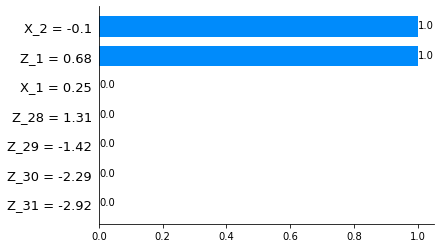

In [47]:
fig = bar_legacy(lximp[0], features=np.round(x[0], 2), feature_names=columns_name) # LXI importance

In [41]:
from shap import TreeExplainer
from skranger.ensemble import RangerForestClassifier
from skranger.utils.shap import shap_patch

with shap_patch():
    explainer = TreeExplainer(model=acv_xplainer.model)

In [42]:
shap_values = explainer.shap_values(x)[1]

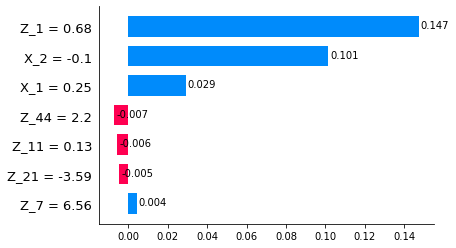

In [46]:
fig_shap = bar_legacy(shap_values[0], features=np.round(x[0], 2), feature_names=columns_name) # shap values

### Plotting mean attributions

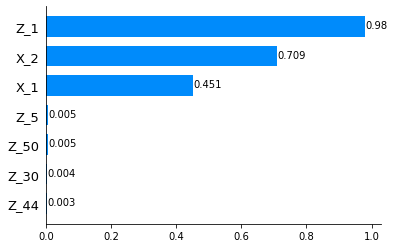

In [44]:
fig = bar_legacy(np.mean(lximp, axis=0), feature_names=columns_name) # LXI mean importance

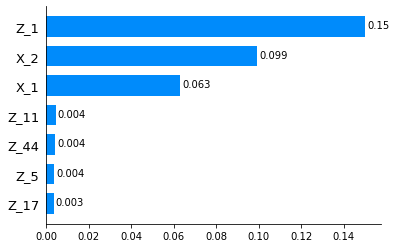

In [45]:
fig = bar_legacy(np.mean(np.abs(shap_values), axis=0), feature_names=columns_name) # SHAP mean absolute importance